# Прогнозирование спроса товаров собственного производства


### Описание задачи

Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного производства. Гранулярность ТК-SKU-День.
 

### Описание данных

1. **sales_df_train.csv** –данные по продажам за скользящий год для обучения.

     * *st_id* – захэшированное id магазина;
     * *pr_sku_id* – захэшированное id товара;
     * *date* – дата;
     * *pr_sales_type_id* – флаг наличия промо;
     * *pr_sales_in_units* – число проданных товаров без признака промо;
     * *pr_promo_sales_in_units* – число проданных товаров с признаком промо;
     * *pr_sales_in_rub* – продажи без признака промо в РУБ;
     * *pr_promo_sales_in_rub* – продажи с признаком промо в РУБ;


2. **pr_df.csv** – данные по товарной иерархии.

    * *pr_group_id* – захэшированная группа товара;
    * *pr_cat_id* – захэшированная категория товара;
    * *pr_subcat_id* – захэшированная подкатегория товара;
    * *pr_sku_id* – захэшированное id товара;
    * *pr_uom_id* (маркер, обозначающий продаётся товар на вес или в ШТ).
    
    
    
3. **pr_st.csv** – данные по магазинам.

    * *st_id* – захэшированное id магазина;
    * *st_city_id* – захэшированное id города;
    * *st_division_code id* – захэшированное id дивизиона;
    * *st_type_format_id* – id формата магазина;
    * *st_type_loc_id* – id тип локации/окружения магазина;
    * *st_type_size_id* – id типа размера магазина;
    * *st_is_active* – флаг активного магазина на данный момент.



## Первичное ознакомление с данными

In [1]:
# Установка необходимых библиотек
!pip install statsmodels
!pip install catboost
!pip install lightgbm
!pip install xgboost 
!pip install --upgrade tables
!pip install blosc2~=2.0.0
!pip install pmdarima
!pip install phik==0.10.0
!pip install calmap

In [2]:
# Импорт библиотек
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import phik
import calmap

from joblib import Parallel, delayed
from phik.report import plot_correlation_matrix
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from lightgbm import LGBMRegressor


warnings.filterwarnings('ignore')

In [3]:
# Построение графика изменения продаж товаров в штуках с рампределением по месяцам
def plot_cat_sales(data, name,  date, column1, column2, column3):
    
    df = data[data[column1] == name][[date, column2, column3]]
    df[date] = pd.to_datetime(df[date])
    df.set_index(date, inplace=True)
    pivot_table = df.pivot_table(index=df.index.month, columns=column2, values=column3, aggfunc='sum')

    plt.figure(figsize=(15, 5))
    
    sns.lineplot(data=pivot_table)
    plt.legend(loc='upper left')
    plt.xlabel('Месяц')
    plt.ylabel('Количество товара')
    plt.title(f'Изменение продаж товаров {name} группы по категориям по месяцам')
    plt.show()
    
    
# Установка даты в качестве индекса для создаваемых срезов таблицы при анализе
def set_date_index(input_df, col_name='date'):
    
    modified_df = input_df.copy()
    modified_df[col_name] = pd.to_datetime(modified_df[col_name])
    modified_df.set_index(col_name, inplace=True)

    return modified_df    


# Подсчет строк с отрицательными значениями в столбце
def neg_val(data, column):
    count = len(data[data[column] < 0])
    
    return count

# Расчет WAPE по скользящему среднему
def rolling_wape(y_true, y_pred):
    rolling_wape = np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))
    return rolling_wape

Загрузим исходные данные и выведем первичную информацию о данных. 

In [4]:
data_dir = 'C:/Users/tra88/Downloads/Лента/sp_sales_task'
try:
    df_train = os.path.join(data_dir, 'sales_df_train.csv')
    train = pd.read_csv(df_train)
    
    df_pr = os.path.join(data_dir, 'pr_df.csv')
    pr = pd.read_csv(df_pr)
    
    df_st_df = os.path.join(data_dir, 'st_df.csv')
    st_df = pd.read_csv(df_st_df)
    
    df_holiday = os.path.join(data_dir, 'holidays_covid_calendar.csv')
    holiday = pd.read_csv(df_holiday)
    
except:
    train = pd.read_csv('sales_df_train.csv')
    pr = pd.read_csv('pr_df.csv')
    st_df = pd.read_csv('st_df.csv')
    holiday = pd.read_csv('holidays_covid_calendar.csv')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB


In [6]:
pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


In [7]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 804.0+ bytes


В датафрейме train присутствует столбец date, содержащий дату продажи. Его необходимо привести к соответствующему типу данных

In [8]:
train['date'] = pd.to_datetime(train['date'])

Для получения большей информации о имеющихся данных необходимо обьединить исходные датафреймы в единый. Обьединение возможно по столбцам pr_sku_id и st_id.

In [9]:
temp_df = pd.merge(train, pr, on='pr_sku_id')
df = pd.merge(temp_df, st_df, on='st_id')
del temp_df

В данных присутствуют захэшированные названия, которые при анализе будут крайне неудобны из-за своей громоздкости, поэтому их необходимо закодировать просто номерами.

In [10]:
# Создаем копию датафрейма
df_num = df.copy()

# Создаем словарь для хранения объектов LabelEncoder для каждого столбца
label_encoders = {}

for column_name in df.columns:
    if df[column_name].dtype == 'object':  # Проверяем, является ли столбец хэшированным
        le = LabelEncoder()
        df_num[column_name] = le.fit_transform(df[column_name])
        label_encoders[column_name] = le

Выведем размеры полученного датафрейма, проверим на наличие явных дубликатов и выведем информацию о содержащихся в нем данных.

In [11]:
print('Размер датафрейма:', df_num.shape)
print('Количество явных дубликатов:', df_num.duplicated().sum())

Размер датафрейма: (883015, 18)
Количество явных дубликатов: 0


In [12]:
df_num.describe()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
count,883015.000000,883015.000000,883015,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000
mean,6.533965,986.529361,2023-01-25 18:19:37.852697856,0.406486,5.037956,2.230010,596.705181,294.766561,6.187769,19.021626,83.996075,6.751821,3.719790,1.873242,1.096438,1.206916,11.464332,0.999174
min,0.000000,0.000000,2022-08-01 00:00:00,0.000000,-39.000000,-39.000000,-3373.000000,-3373.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,8.000000,0.000000
25%,4.000000,515.000000,2022-10-29 00:00:00,0.000000,1.000000,0.000000,98.000000,0.000000,5.000000,4.000000,41.000000,1.000000,2.000000,0.000000,1.000000,1.000000,8.000000,1.000000
50%,7.000000,905.000000,2023-01-27 00:00:00,0.000000,2.000000,0.000000,224.000000,0.000000,6.000000,17.000000,89.000000,1.000000,3.000000,2.000000,1.000000,1.000000,12.000000,1.000000
75%,10.000000,1502.000000,2023-04-25 00:00:00,1.000000,4.000000,1.000000,540.000000,127.000000,8.000000,28.000000,132.000000,17.000000,5.000000,4.000000,1.000000,1.000000,12.000000,1.000000
max,11.000000,1990.000000,2023-07-18 00:00:00,1.000000,2348.000000,2348.000000,183265.000000,183265.000000,8.000000,42.000000,166.000000,17.000000,6.000000,5.000000,4.000000,3.000000,32.000000,1.000000
std,3.552645,572.384504,NaN,0.491178,13.402984,11.063288,1577.366179,1402.764168,1.885313,12.909207,48.320331,7.677614,1.719405,1.618767,0.415505,0.438867,4.509462,0.028721


Из информации по таблице мы видим, что в данных присутствуют отрицательные значения в столбцах 'pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub' и 'pr_promo_sales_in_rub'. Посмотрим, какие количество строк таких значений.

In [13]:
# Подсчет строк в столбцах с отрицательным значением
negative_column = ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']

for col in negative_column:
    print(f'Количество строк с отрицательным значением в столбце {col}:', neg_val(df_num, col))

Количество строк с отрицательным значением в столбце pr_sales_in_units: 71
Количество строк с отрицательным значением в столбце pr_promo_sales_in_units: 35
Количество строк с отрицательным значением в столбце pr_sales_in_rub: 78
Количество строк с отрицательным значением в столбце pr_promo_sales_in_rub: 36


Таких строк не очень много, скорее всего это возвраты товаров. поэтому лучше их просто исключить из дальнейшего анализа.

In [14]:
df_num = df_num.loc[(df_num['pr_sales_in_units'] >= 0) & (df_num['pr_promo_sales_in_units'] >= 0) 
                    & (df_num['pr_sales_in_rub'] >= 0) & (df_num['pr_promo_sales_in_rub'] >= 0)]

**Вывод:**
1. Данные представлены в 3 таблицах, которые  были соединены в единую таблицу.
2. Итоговый датафрейм содержит 883015 строк и 18 столбцов. 
3. Столбец date содержит информацию о датах продаж, поэтому был приведен к формату datetime.
4. В некоторых столбцах содержится захэшированная информация, которая при визуализации и изучении данных будет неудобна. Поэтому был создан словарь с хэшированными данными и присвоенными им числами.
5. При первичном ознакомлении с данными пропусков не было обнаружено, но в данных присутствует небольшое количество отрицательных значений. Поскольку нам предоставлены данные о продажах, то отрицательные значения могли возникнуть по нескольким причинами: возврат товар, списание товара или ошибка при выгрузке данных. Такие данные решили исключить из анализа, поскольку количество таких позиций небольшое, а природа происхождения не ясна.

# EDA 

Посмотрим есть ли продажи с нулевым количеством проданных товаров.

In [15]:
df_num.query('pr_sales_in_units == 0')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
3,9,1555,2023-06-22,0,0.0,0.0,79.0,0.0,5,4,147,1,3,2,1,1,8,1
10,9,1555,2023-06-18,1,0.0,0.0,74.0,74.0,5,4,147,1,3,2,1,1,8,1
29,9,1555,2023-05-03,0,0.0,0.0,81.0,0.0,5,4,147,1,3,2,1,1,8,1
69,9,1555,2022-08-24,0,0.0,0.0,56.0,0.0,5,4,147,1,3,2,1,1,8,1
99,9,1555,2023-04-27,0,0.0,0.0,72.0,0.0,5,4,147,1,3,2,1,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882597,8,1874,2023-03-17,1,0.0,0.0,43.0,43.0,5,1,112,1,4,5,4,3,19,1
882733,8,922,2022-08-21,0,0.0,0.0,0.0,0.0,8,36,131,17,4,5,4,3,19,1
882783,8,1359,2022-10-09,1,0.0,0.0,0.0,0.0,8,36,131,17,4,5,4,3,19,1
882863,8,760,2023-05-03,0,0.0,0.0,0.0,0.0,8,15,117,17,4,5,4,3,19,1


In [16]:
# Процент продаж с нулевым количеством проданных товаров.
len(df_num.query('pr_sales_in_units == 0')) / len(df_num) *100

7.535653773319924

Есть очень странные позиции товаров, поскольку количество проданных товаров равно нулю, но при этом имеется указана сумма продаж для данных товаров. Возможно, это проблема, возникшая при выгрузке данных. Заполнить их мы никак не сможем, поэтому такие данные необходимо убрать.

In [17]:
df_num = df_num.query('pr_sales_in_units > 0')


Посмотрим есть ли товары, у которых сумма продаж равна нулю.

In [18]:
df_num.query('pr_sales_in_rub == 0')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
720,9,242,2023-01-05,1,1.0,1.0,0.0,0.0,8,36,58,17,3,2,1,1,8,1
1456,9,365,2022-10-29,1,22.0,22.0,0.0,0.0,8,2,142,17,3,2,1,1,8,1
1516,9,365,2022-10-11,1,21.0,21.0,0.0,0.0,8,2,142,17,3,2,1,1,8,1
1623,9,365,2023-05-15,1,31.0,31.0,0.0,0.0,8,2,142,17,3,2,1,1,8,1
1790,9,365,2023-05-18,1,56.0,56.0,0.0,0.0,8,2,142,17,3,2,1,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880238,5,1959,2023-01-25,1,1.0,1.0,0.0,0.0,8,20,52,17,4,5,4,3,20,1
880256,5,1959,2023-01-16,1,1.0,1.0,0.0,0.0,8,20,52,17,4,5,4,3,20,1
880297,5,1984,2023-02-10,1,1.0,1.0,0.0,0.0,8,15,77,17,4,5,4,3,20,1
880520,8,1376,2022-08-10,1,1.0,1.0,0.0,0.0,8,2,142,17,4,5,4,3,19,1


In [19]:
# Процент продаж с нулевыми продажами в рублях.
len(df_num.query('pr_sales_in_rub == 0')) / len(df_num) *100

0.09725612780974056

Процент таких товаров не большой, но такие позиции можно попробовать заполнить. Заполним их произведением продаж товара в штуках на стоимость товар. Стоимость товара рассчитаем делением суммы продаж на количество. Нулевые значения по стоимости товара заполним средним значением стоимости товара по каждой позиции.

In [20]:
df_num['price'] = round(df_num['pr_sales_in_rub'] / df_num['pr_sales_in_units'], 2)
mean_price = df_num.groupby('pr_sku_id')['pr_sales_in_rub'].mean()

zero_sales = df_num['pr_sales_in_rub'] == 0.0
# Замена значения 0.0 в столбце price и pr_sales_in_rub
df_num.loc[zero_sales, 'price'] = df_num.loc[zero_sales, 'pr_sku_id'].map(mean_price)
df_num.loc[zero_sales, 'pr_sales_in_rub'] = df_num.loc[zero_sales, 'pr_sku_id'].map(mean_price) * df_num.loc[zero_sales, 'pr_sales_in_units']

Посмотрим на распределение категориальных признаков в датафрейме.

In [21]:
# Создание списка категориальных признаков
cat_cols = ['st_id', 'pr_sales_type_id', 'pr_group_id', 'pr_cat_id', 
            'pr_uom_id', 'st_city_id', 'st_division_code',
            'st_type_format_id', 'st_type_loc_id', 'st_type_size_id',
            'st_is_active']

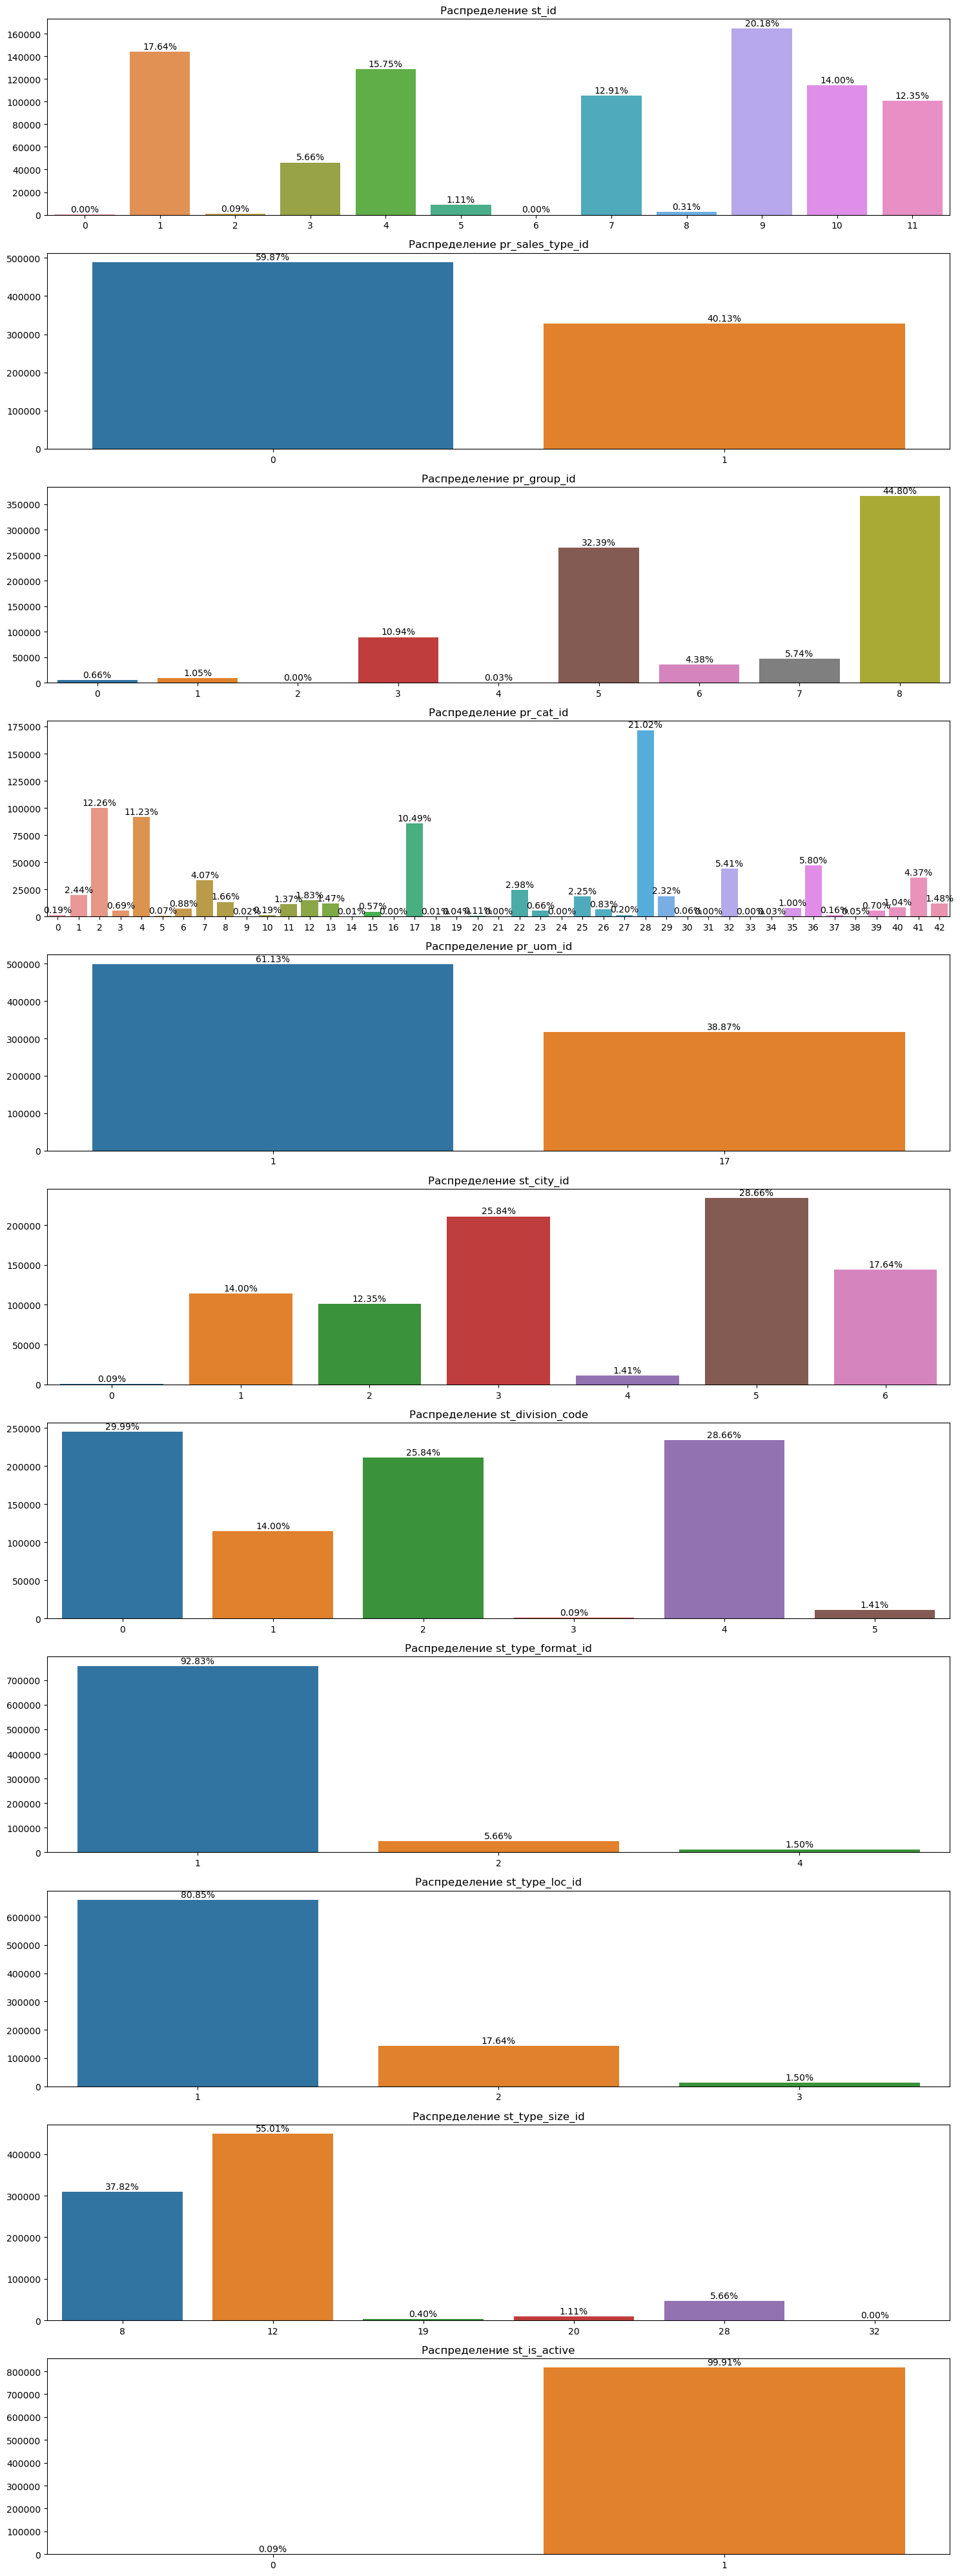

In [22]:
cols = 1
rows = len(cat_cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 40), dpi=100)

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(data=df_num, x=col, ax=ax)
    ax.set_title(f"Распределение {col}")
    ax.set(xlabel=None, ylabel=None)

    total = len(df_num)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')

plt.tight_layout()
plt.show()

На основе графиков можно сделать следующие выводы:

1. В группировке товаров можно выделить топ-3:
      * Группа №8 - 44,8%
      * Группа №5 - 32,39%
      * Группа №3 - 10.94%
      
      
2. В нашем распоряжении данные 12 магазинов. Очень мало данных о магазинах с номером 0, 2, 6 и 8. Продажи этих магазинов составляют менее 1% от общего обьема данных.


3. Среди категорий товара также можно выделить ТОП наиболее продаваемых категорий:
     * Категория №28 - 21.02%
     * Категория №2 - 12.26%
     * Категория №4 - 11.23%
     * Категория №17 - 10.49% 
     
4. Магазины располагаются в 7 городах.


5. В столбце st_is_active представлена о статусе активности магазина в настоящее время. Видно, что в данных присутствует малое количество неактивных магазинов. Их необходимо исключить. И столбец st_is_active можно будет после этого удалить, т.к. не будет нести никаой смысловой информации для нас.

6. В столбце st_type_size_id со значением 32 имеет количество практически равное нулю.

На графиках были видны магазин с малым количеством информации. Это магазины 0, 2,  6 и 8. Неплохо изучить информацию о самих магазинах, поскольку малое количество информации может быть из-за того, что магазин недавно только открыли. 

Для начала составим информацию о каждом магазине: его продажах, уникальных товаров, наиболее популярных товарах.

In [23]:
unique_sku_by_store = {}

df_grouped = df_num.groupby('st_id')

for store_id, df_store in df_grouped:
    pr_sku_id_store = df_store['pr_sku_id'].unique()
    unique_sku_id = []
    
    for pr in pr_sku_id_store:
        num = len(df_grouped.get_group(store_id).query('pr_sku_id == @pr'))
        if num == 1:
            unique_sku_id.append(pr)
    
    store_name = df_store['st_id'].iloc[0]
    first_sale_date = df_store['date'].min()
    last_sale_date = df_store['date'].max()
    total_sales = round(df_store['pr_sales_in_rub'].sum(), 2)
    popular_items = df_store.groupby(['pr_cat_id', 'pr_sku_id']).agg({'pr_sales_in_units': 'sum', 'pr_sales_in_rub': 'sum'}).nlargest(5, 'pr_sales_in_units')
    percent_unique_sku = round(len(unique_sku_id) / len(pr_sku_id_store) * 100, 2)
    
    unique_sku_by_store[store_id] = {
        'Наименование магазина': store_name,
        'Дата первой продажи': first_sale_date,
        'Дата последней продажи': last_sale_date,
        'Уникальные позиции магазина': unique_sku_id,
        'Сумма продаж за все время': total_sales,
        'Процент уникальных товаров': percent_unique_sku,
        'Наиболее популярные товары': popular_items,
    }

for store_id, store_data in unique_sku_by_store.items():
    print('*'*100)
    print(f"Store ID: {store_id}")
    for key, value in store_data.items():
        print(f"{key}: {value}")
    print('*'*100)
    print()

****************************************************************************************************
Store ID: 0
Наименование магазина: 0
Дата первой продажи: 2023-03-26 00:00:00
Дата последней продажи: 2023-06-29 00:00:00
Уникальные позиции магазина: [729]
Сумма продаж за все время: 6836.0
Процент уникальных товаров: 16.67
Наиболее популярные товары:                      pr_sales_in_units  pr_sales_in_rub
pr_cat_id pr_sku_id                                    
22        1020                    16.0           2114.0
          1506                    15.0           2239.0
          22                      10.0           1251.0
41        1524                     5.0            692.0
22        1472                     2.0            420.0
****************************************************************************************************

****************************************************************************************************
Store ID: 1
Наименование магазина: 1
Дата первой пр

* У большинства магазинов есть свои уникальные товары, которые продаются, то в их магазине. Исключением из этого являются магазины 2 и 6. В этих магазинах нет уникальных товаров, характерных только для этих магазинов. 

* Магазин с id 0 имеет малое количество продаж. Судя по датам этот магазин относительно недавно открылся, поэтому информации по нему крайне мало. Этот магазин следует исключить из дальнейшего исследования, поскольку информация по нему не информативна.

* Магазин с id 2 имеет крайне странные продажи(ровно 1 месяц). Обьем таких продаж крайне мал, поэтому этот магазин также исключаем из дальнейшего анализа.

* Магазин с id 6 не информативен для нас, поскольку осуществлял продажи только в период с 24 августа по 8 сентября, при этом сумма продаж составила всего лишь 3498 рублей и продавали всего лишь 2 позиции. Поэтому этот магазин тоже необходимо исключить.


Также на графиках видно, что у нас представлено очень маленькое количество товаров 2 и 3 группы. Такие группы следует исключить из дальнейшего исследования.

Исключим данные, которые было решено убрать.

In [24]:
df_num = df_num.query('st_id != (0, 2, 6)')
df_num = df_num.query('pr_group_id != (0, 2, 4)')
df_num = df_num.query('st_is_active != 0')
df_num = df_num.drop('st_is_active', axis=1)

Посмотрим на распределение продаж в штуках во времени.

In [25]:
# Создание среза таблицы для просмотра общих продаж в штуках во времени 
df_a = df[['date', 'pr_sales_in_units']]
df_a = set_date_index(df_a, 'date')
df_a = df_a.resample('1d').sum()

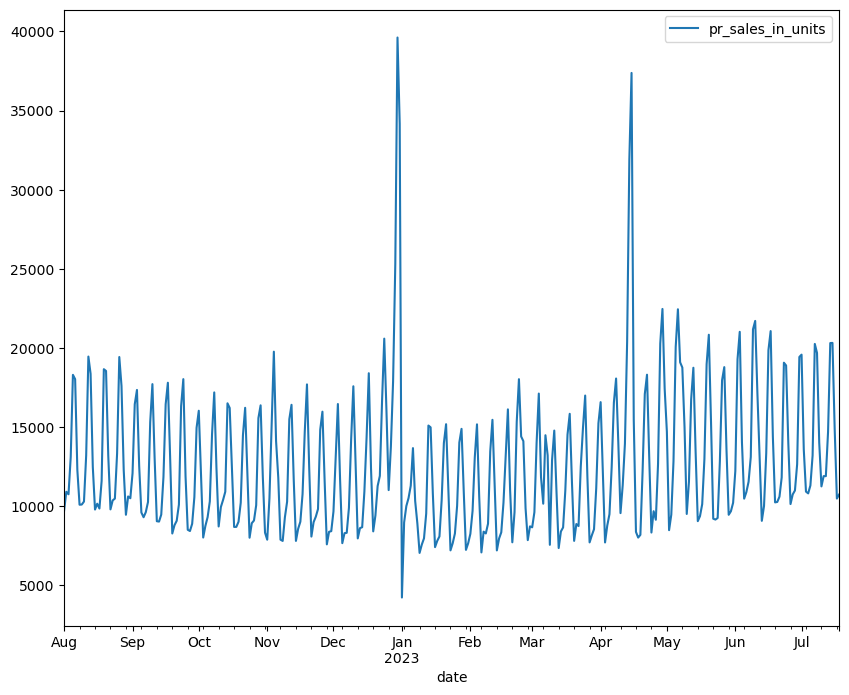

In [26]:
# Вывод графика распределения общих продаж
df_a.plot(figsize=(10, 8))
plt.show()

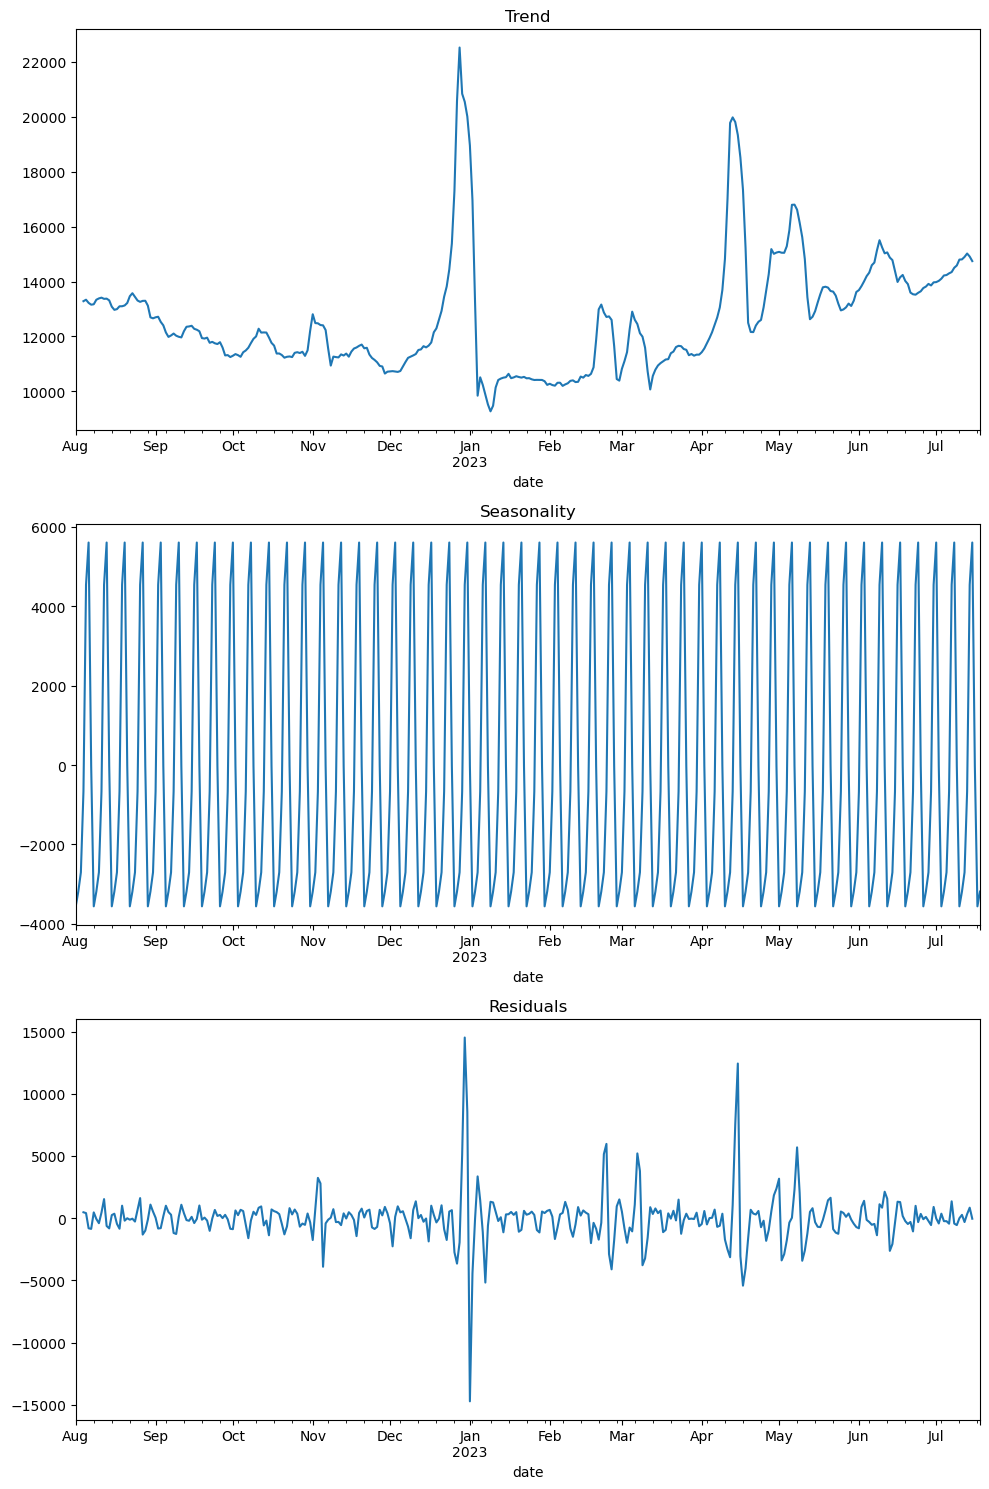

In [27]:
# Визуализация трендов,сезонности общих продаж во времени
decomposed = seasonal_decompose(df_a)

plt.figure(figsize=(10, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По полученным графикам видно, что в конце декабря имеется очень большой скачок продаж, а потом резкое падение. Такой подьем продаж можно объяснить тем, что происходит празднование Нового года. А вот падение приходится на начало января. Это может быть связано со списанием товаров с ограниченным сроком годности.


В целом на графике с трендами видны всплески продаж в период праздников. Например,  в конце февраля - начале марта (23 февраля, 8 марта, масленица) или апрель - май (пасха, 1 мая, 9 мая). Самый низкий тред продаж на графике - это январь-февраль, самый высокий декабрь.

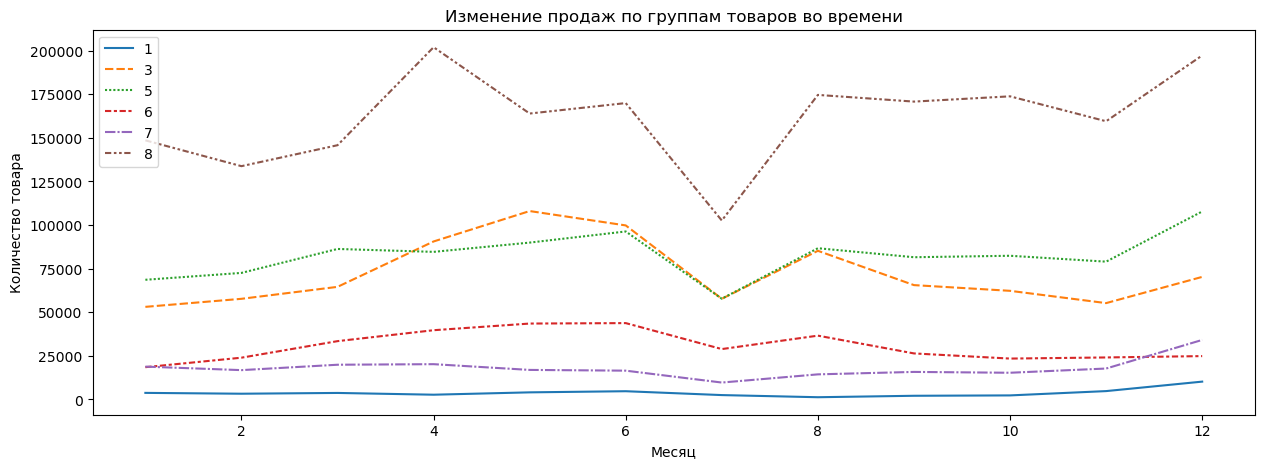

In [28]:
#  Визуализация распределения общих продаж каждой группы товаров во времени
df_plot = df_num[['date', 'pr_group_id', 'pr_sales_in_units']].copy()
df_plot = set_date_index(df_plot, 'date')
pivot_table = df_plot.pivot_table(index=df_plot.index.month, columns='pr_group_id', values='pr_sales_in_units', aggfunc='sum')


plt.figure(figsize=(15, 5))
sns.lineplot(data=pivot_table)

plt.legend(loc='upper left')
plt.xlabel('Месяц')
plt.ylabel('Количество товара')
plt.title('Изменение продаж по группам товаров во времени')

plt.show()

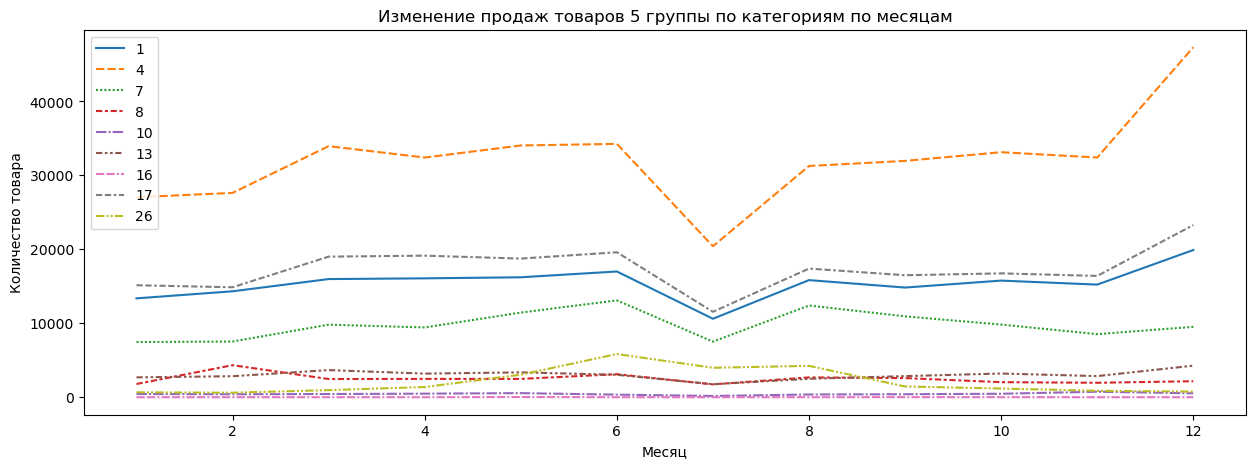

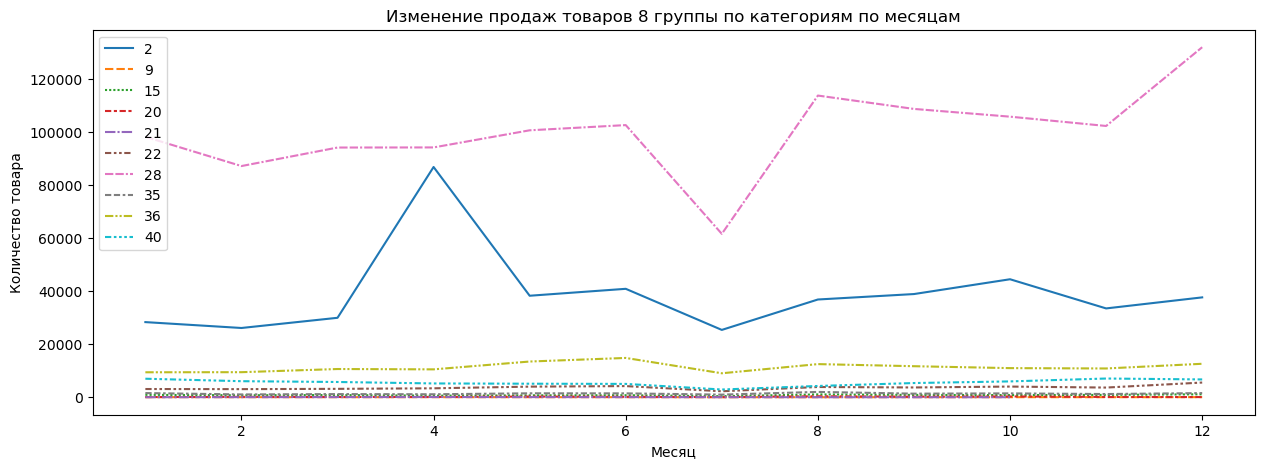

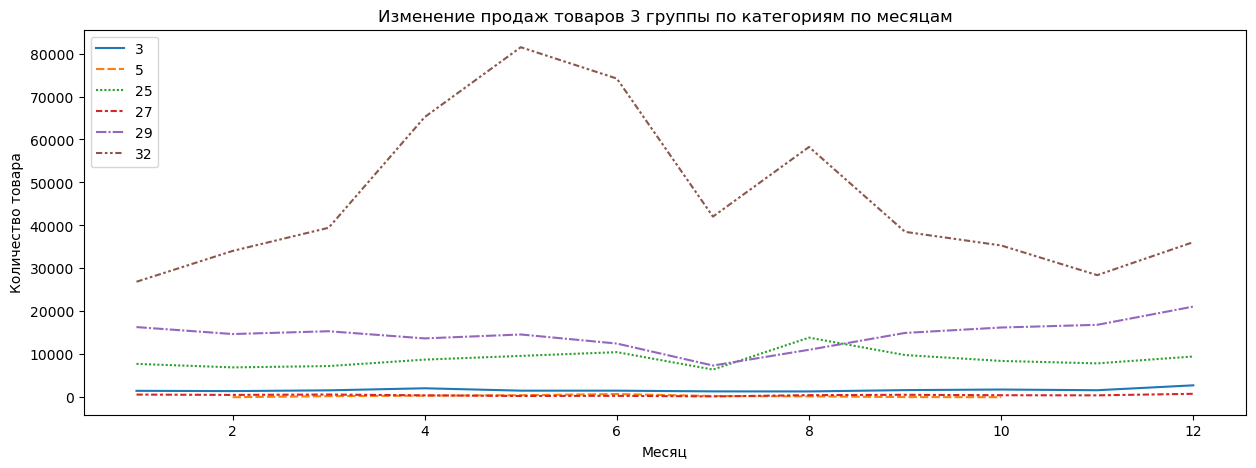

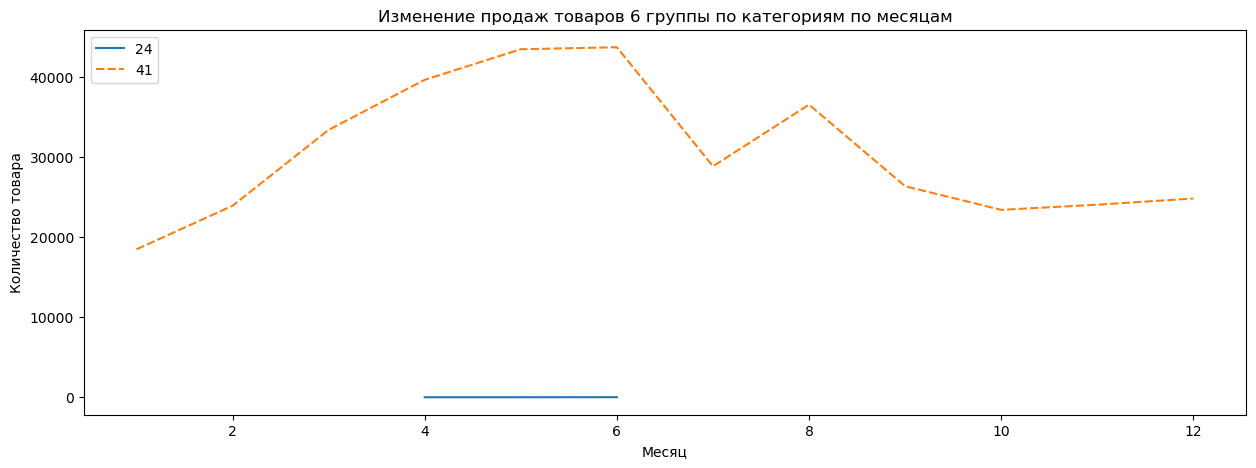

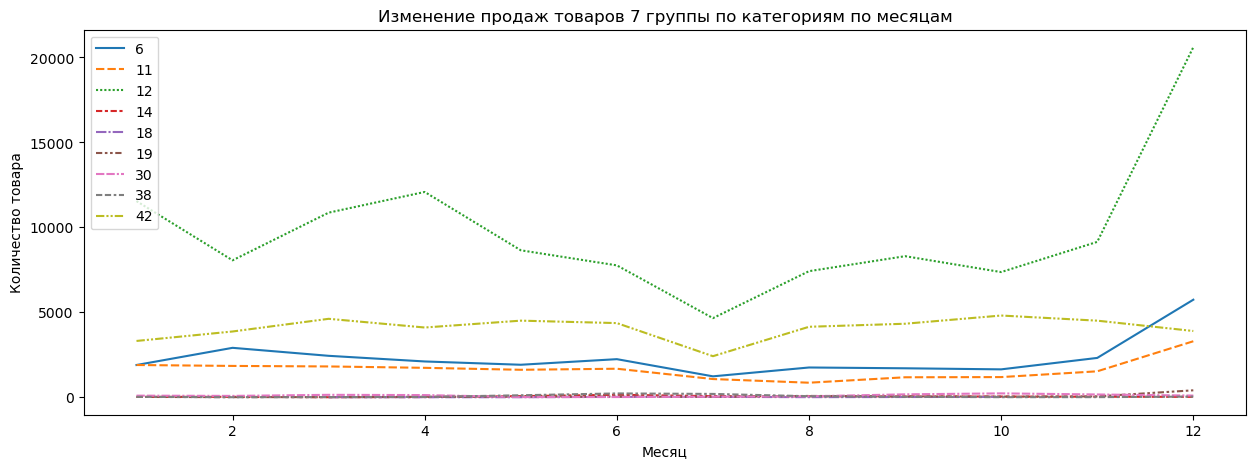

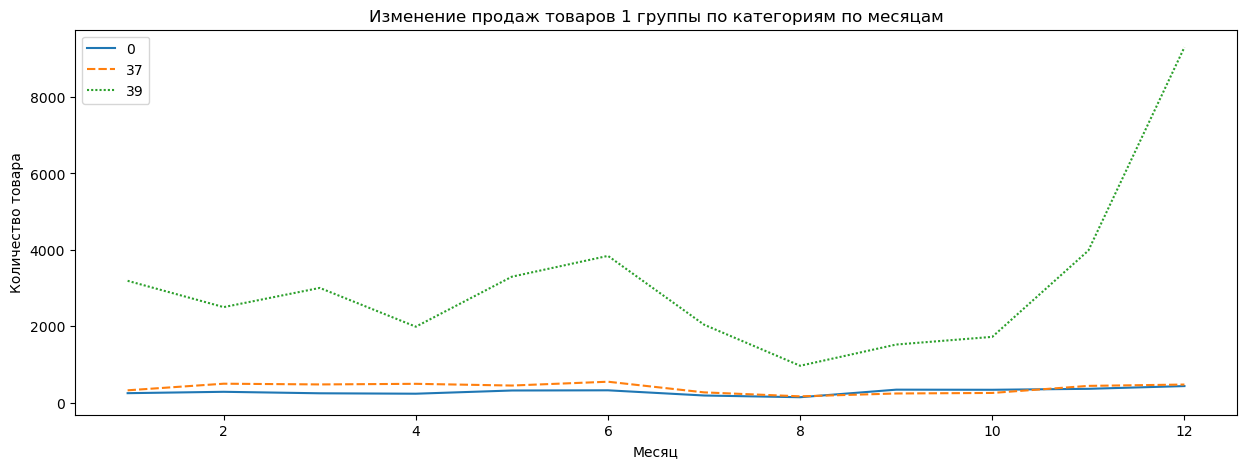

In [29]:
# Визуализация продаж категорий товаров внутри групп во времени
name_group_id = df_num['pr_group_id'].unique()

for name in name_group_id:
    plot_cat_sales(df_num, name,  'date', 'pr_group_id', 'pr_cat_id', 'pr_sales_in_units')
    

На графике 6 группы товаров странное отображение категорий товаров 24. Категория 24 продавалась с апреля по июнь. Сделаем срез по этой категории и посмотрим, на продажи этих товаров.

In [30]:
df_num.query('pr_cat_id == 24')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,price
172342,9,185,2023-06-06,0,1.0,0.0,115.0,0.0,6,24,12,1,3,2,1,1,8,115.00
172343,9,185,2023-05-01,0,1.0,0.0,113.0,0.0,6,24,12,1,3,2,1,1,8,113.00
172344,9,185,2023-06-23,0,1.0,0.0,252.0,0.0,6,24,12,1,3,2,1,1,8,252.00
172345,9,185,2023-06-03,0,1.0,0.0,115.0,0.0,6,24,12,1,3,2,1,1,8,115.00
172346,9,185,2023-05-26,0,2.0,0.0,338.0,0.0,6,24,12,1,3,2,1,1,8,169.00
172347,9,185,2023-06-24,0,1.0,0.0,252.0,0.0,6,24,12,1,3,2,1,1,8,252.00
172348,9,185,2023-04-28,0,1.0,0.0,111.0,0.0,6,24,12,1,3,2,1,1,8,111.00
172349,9,185,2023-05-24,0,1.0,0.0,225.0,0.0,6,24,12,1,3,2,1,1,8,225.00
172350,9,185,2023-05-07,1,1.0,1.0,97.0,97.0,6,24,12,1,3,2,1,1,8,97.00
172351,9,185,2023-04-29,0,1.0,0.0,113.0,0.0,6,24,12,1,3,2,1,1,8,113.00


Товары категории 24 присутствуют в минимальном количестве. делать прогнозы по товару этой категории не стоит, поскольку данных крайне мало для прогнозирования.

In [31]:
df_num = df_num.query('pr_cat_id != 24')

Построим график кол-ва проданных, скользящего среднего и стандартного отклонения

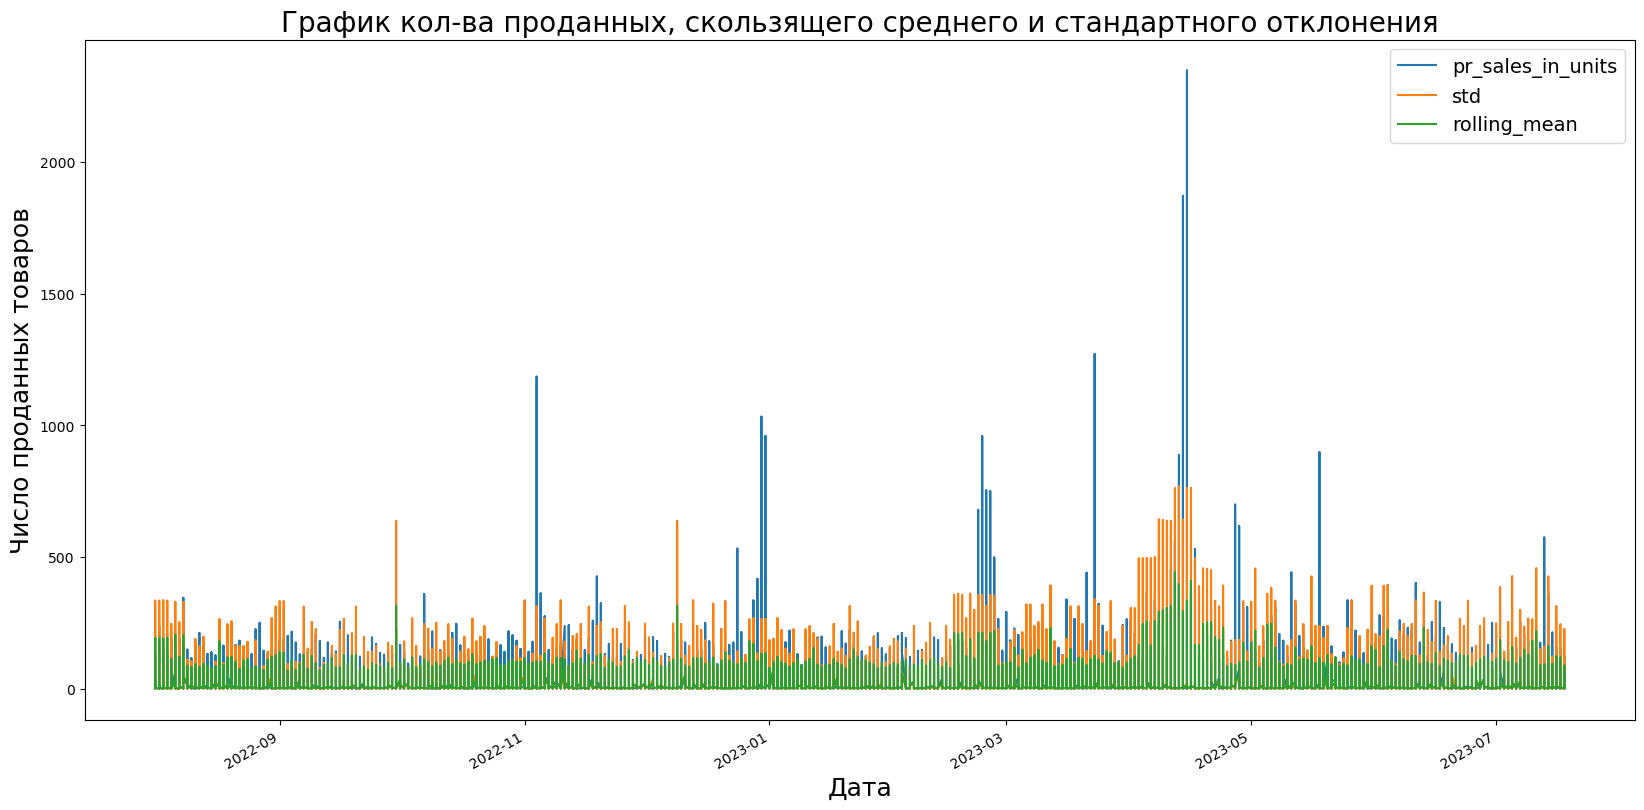

In [32]:
units_mean_std = df_num.copy()

units_mean_std['rolling_mean'] = units_mean_std['pr_sales_in_units'].rolling(14).mean()
units_mean_std['std'] = units_mean_std['pr_sales_in_units'].rolling(14).std()

ax = units_mean_std[['date', 'pr_sales_in_units', 'std', 'rolling_mean']].plot(figsize=(20, 10), 
                                                                              x='date')

ax.set_title('График кол-ва проданных, скользящего среднего и стандартного отклонения', fontsize=20)
ax.set_xlabel('Дата', fontsize=18)
ax.set_ylabel('Число проданных товаров', fontsize=18)
ax.legend(fontsize=14)
plt.show()


На графике видно, что есть сильные всплески в период с марта по май. Тут самое большое количество проданных товаров. Одним вариантом обьяснения такого всплеска может быть наличие праздника(например Пасха, 1 мая, 9 мая).  

Также присутствуют всплески в ноябре и в период с декабря по март. Но не очень большие по сравнению со всплеском в период с марта по май. 


Построим матрицу корреляции данных.

In [33]:
phik_overview = df_num.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['st_id', 'pr_sku_id', 'pr_sales_type_id', 'pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id', 'st_city_id', 'st_division_code', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'price']


,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,price
st_id,1.00,0.08,0.07,0.08,0.00,0.00,0.02,0.02,0.14,0.18,0.13,0.30,0.96,0.93,1.00,1.00,0.96,0.03
pr_sku_id,0.08,1.00,0.00,0.04,0.01,0.01,0.03,0.02,0.30,0.42,0.37,0.22,0.07,0.09,0.09,0.06,0.11,0.09
date,0.07,0.00,1.00,0.11,0.05,0.05,0.05,0.04,0.06,0.06,0.04,0.04,0.07,0.07,0.08,0.06,0.08,0.03
pr_sales_type_id,0.08,0.04,0.11,1.00,0.01,0.02,0.03,0.04,0.25,0.20,0.10,0.08,0.10,0.06,0.03,0.03,0.04,0.05
pr_sales_in_units,0.00,0.01,0.05,0.01,1.00,1.00,0.58,0.57,0.01,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
pr_promo_sales_in_units,0.00,0.01,0.05,0.02,1.00,1.00,0.58,0.60,0.02,0.02,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00
pr_sales_in_rub,0.02,0.03,0.05,0.03,0.58,0.58,1.00,1.00,0.06,0.06,0.03,0.02,0.02,0.02,0.01,0.03,0.01,0.08
pr_promo_sales_in_rub,0.02,0.02,0.04,0.04,0.57,0.60,1.00,1.00,0.06,0.06,0.03,0.02,0.02,0.01,0.01,0.03,0.01,0.07
pr_group_id,0.14,0.30,0.06,0.25,0.01,0.02,0.06,0.06,1.00,0.86,0.55,0.85,0.19,0.11,0.26,0.20,0.13,0.38
pr_cat_id,0.18,0.42,0.06,0.20,0.02,0.02,0.06,0.06,0.86,1.00,0.76,0.83,0.17,0.23,0.21,0.13,0.26,0.27


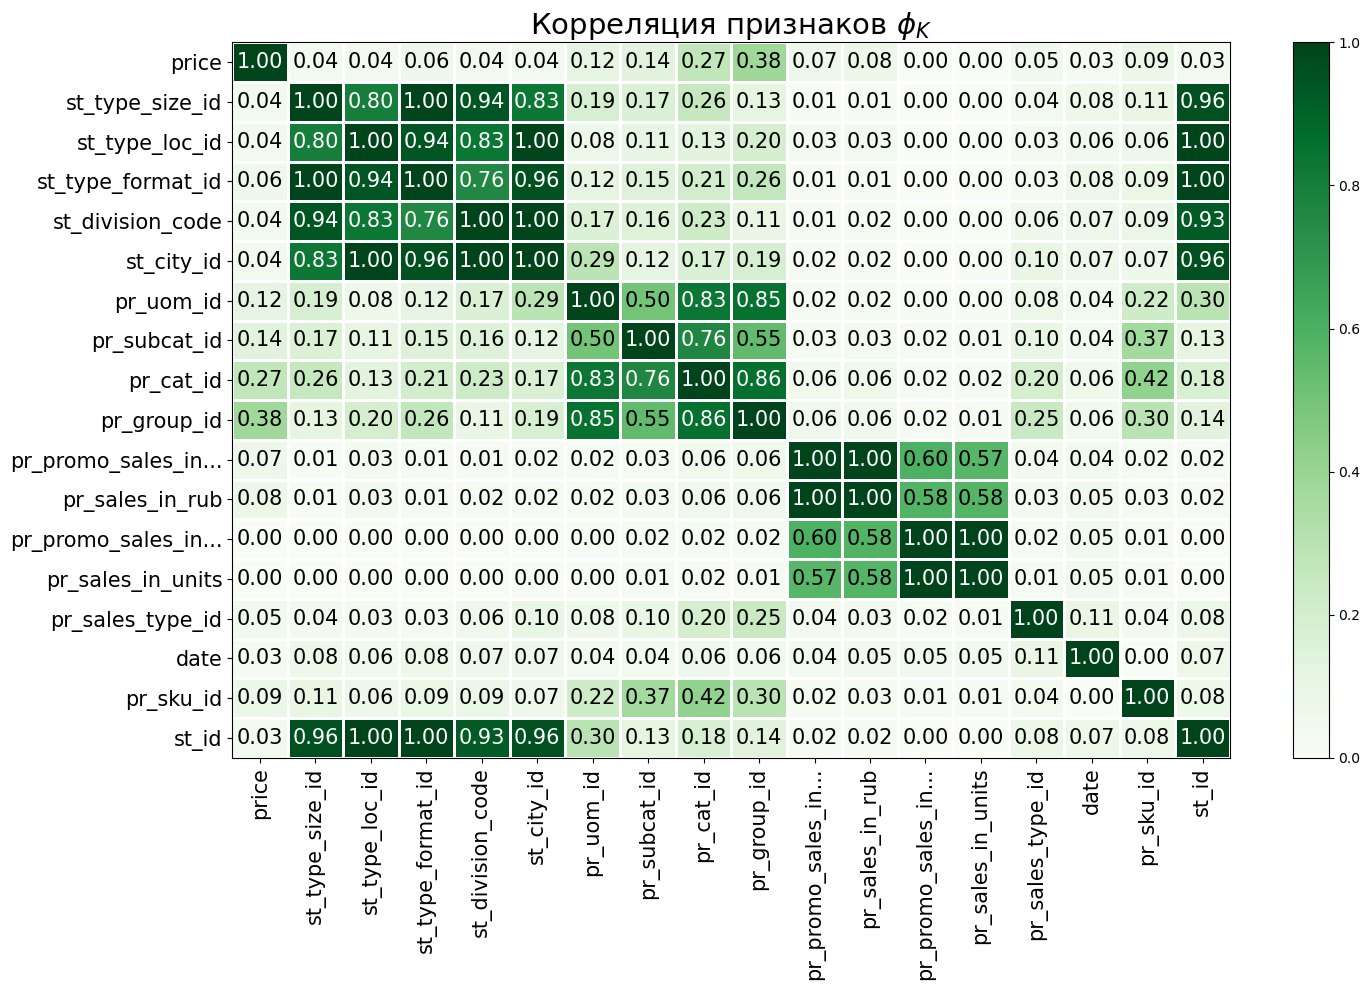

In [34]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Корреляция признаков $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 10))
plt.tight_layout()

In [35]:
del units_mean_std
del df_plot
del pivot_table
del df_a
del df
del train
del pr
del st_df
del df_grouped
del phik_overview

**Вывод:**


При изучении общего распределения данных было выявлено следующее:


1. При исследовании групп товаров можно выделить топ-3:
   * Группа №8 - 44,8%
   * Группа №5 - 32,39%
   * Группа №3 - 10.94%
2. В нашем распоряжении данные 12 магазинов из 7 городов. Очень мало данных о магазинах с номером 0, 2, 6 и 8. Продажи этих магазинов составляют менее 1% от общего объёма данных.
3. Среди категорий товара также можно выделить ТОП наиболее продаваемых категорий:
   * Категория №28 - 21.02%
   * Категория №2 - 12.26%
   * Категория №4 - 11.23%
   * Категория №17 - 10.49%
4. В столбце st_is_active представлена о статусе активности магазина в настоящее время. Видно, что в данных присутствует малое количество неактивных магазинов. Их необходимо исключить. И столбец st_is_active можно будет после этого удалить, т.к. не будет нести никакой смысловой информации для нас.
5. Товары группы 2 и 3 катастрофически малы, поэтому эти группы были исключены из анализа.
6. Также в данных присутствовала информация о товарах с нулевым количество продаж и не нулевой суммой продаж. Эти данные были исключены. А вот данные с нулевыми суммами продаж были заполнены произведением среднего значения цены для каждой позиции товара на количество проданных товаров.
7. Был создан столбец со стоимостью товар за штуку.


При изучении информации по каждому магазину в отдельности было выявлено следующее:


1. У большинства магазинов есть свои уникальные товары, которые продаются, то в их магазине. Исключением из этого являются магазины 2 и 6. В этих магазинах нет уникальных товаров, характерных только для этих магазинов.
2. Магазин с id 0 имеет малое количество продаж. Судя по датам этот магазин относительно недавно открылся. 
3. Магазин с id 2 имеет крайне странные продажи (ровно 1 месяц). Объём таких продаж крайне мал.
4. Магазин с id 6 осуществлял продажи только в период с 24 августа по 8 сентября, при этом сумма продаж составила всего лишь 3498 рублей и продавали всего лишь 2 позиции.
5. Исключили информацию из данных о магазинах с id 0, 2, 6, поскольку информации о продажах данных магазинов была крайне мала и не информативна.


При изучении информации распределения продаж во времени обнаружено следующее:


1. В конце декабря, в конце февраля – начале марта, апрель – май имеются высокие всплески продаж. Это скорее всего связано с праздниками (Новый год, 23 февраля, 8 марта, масленица, пасха, 1 мая, 9 мая)
2. В январе - феврале имеется сильное падение продаж. Это объяснимо тем, что люди разъехались за город или закупили достаточно продуктов перед новым годом, а также в целом снижением затрат населения на покупку продуктов после праздников.
3. Было обнаружено, что товар с категорий 24 продавался только с апреля по июнь и в минимальном количестве. Эту категорию исключили, поскольку данных недостаточно для прогнозирования.



# Feature engineering

### Создание календаря праздиков в качестве признака.

Созданим новые признаки. Создадим признка указывающий, является ли день праздником или нет. Данные о праздиках содержится в датафрейме holiday.

In [36]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     3653 non-null   int64 
 1   day      3653 non-null   int64 
 2   weekday  3653 non-null   int64 
 3   date     3653 non-null   object
 4   calday   3653 non-null   int64 
 5   holiday  3653 non-null   int64 
 6   covid    3653 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 199.9+ KB


In [37]:
holiday['date'] = pd.to_datetime(holiday['date'], format="%d.%m.%Y", infer_datetime_format=True)

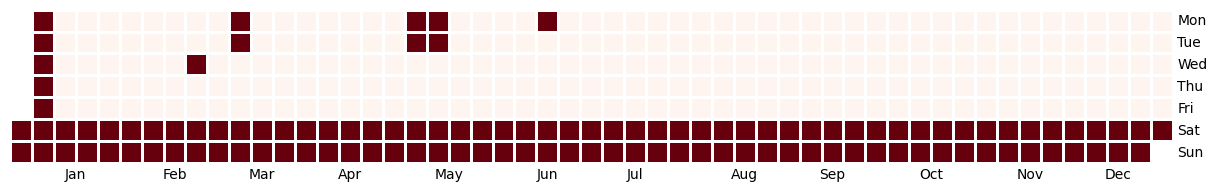

In [38]:
# Построение тепловой карты-календаря
hol = pd.DataFrame(list(holiday['holiday']), index=holiday['date'])
plt.figure(figsize=(15, 15))
calmap.yearplot(hol, year=2022);

In [39]:
# Объединение датафреймов, удалиние лишних столбцов
df_num = pd.merge(df_num, holiday, on='date').drop(['year', 'day', 'weekday', 'calday','covid'], axis=1)

In [40]:
df_num.sample(5)

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,price,holiday
365473,5,1861,2022-10-26,1,2.0,2.0,59.0,59.0,8,2,149,17,4,5,4,3,20,29.50,0
364457,1,1110,2022-10-26,1,3.0,3.0,1642.0,1642.0,7,11,63,1,6,0,1,2,8,547.33,0
222488,1,108,2022-11-30,0,1.0,0.0,23.0,0.0,8,2,66,17,6,0,1,2,8,23.00,0
797238,10,71,2022-08-03,0,6.0,0.0,715.0,0.0,6,41,41,1,1,1,1,1,12,119.17,0
400176,7,900,2023-04-28,1,3.0,3.0,810.0,810.0,3,29,48,1,5,4,1,1,12,270.00,0


### Создание дополнительных лаговых и временных признаков



* pr_sales_in_units_lag - общие продажи за 7 дней в штуках с группировкой по категориям товаров.
* pr_sales_in_rub_lag - общие продажи за 7 дней в рублях с группировкой по категориям товаров..
* pr_sales_in_units_max_lag - максисмальная сумма продаж в штуках за 7 дней с группировкой по категориям товаров.
* pr_sales_in_units_min_lag - минимальная сумма продаж в штуках за 7 дней с группировкой по категориям товаров.
* pr_sales_in_rub_max_lag - максисмальная сумма продаж в рублях за 7 дней с группировкой по категориям товаров.
* pr_sales_in_rub_min_lag - минимальная сумма продаж в рублях за 7 дней с группировкой по категориям товаров.
* mean sales_week_lag - среднее значение продаж за последние 7 дней для каждой группы.
* lag_feature_weekday - день недели.
* month - месяц.
* quarter - квартал.
* lag_feature_4weeks - продажи за 4 недели без группировок
* lag_feature_1week - продажи за 1 неделю без группировки.
* sales_ratio - отношения продаж за 4 недели к продажам за последнюю неделю.
* sales_ratio_cat - отношения продаж товара к продажам во всей категории.
* sales_slope_7d - угловой коэффициент графика продаж товара за последние 7 дней


In [41]:
def generate_features(df_num):
    df_num = df_num.sort_values('date', ascending=False)
    df_num = df_num.assign(
        pr_sales_in_units_lag=df_num.groupby('pr_cat_id')['pr_sales_in_units'].shift(15),
        pr_sales_in_rub_lag=df_num.groupby('pr_cat_id')['pr_sales_in_rub'].shift(15),
        pr_sales_in_units_max_lag=df_num.groupby('pr_cat_id')['pr_sales_in_units'].transform(lambda x: x.rolling(window=15, min_periods=1).max()),
        pr_sales_in_units_min_lag=df_num.groupby('pr_cat_id')['pr_sales_in_units'].transform(lambda x: x.rolling(window=15, min_periods=1).min()),
        pr_sales_in_rub_max_lag=df_num.groupby('pr_cat_id')['pr_sales_in_rub'].transform(lambda x: x.rolling(window=15, min_periods=1).max()),
        pr_sales_in_rub_min_lag=df_num.groupby('pr_cat_id')['pr_sales_in_rub'].transform(lambda x: x.rolling(window=15, min_periods=1).min()),
        mean_sales_week_lag=df_num.groupby(['pr_cat_id', 'pr_sku_id'])['pr_sales_in_units'].transform(lambda x: x.rolling(window=15).mean()),
        lag_feature_weekday=df_num['date'].dt.weekday.shift(1),
        month=df_num['date'].dt.month,
        quarter=df_num['date'].dt.quarter,
        lag_feature_4weeks=df_num['pr_sales_in_units'].rolling(window=29).sum(),
        lag_feature_1week=df_num['pr_sales_in_units'].rolling(window=15).sum(),
        sales_ratio=lambda x: x['lag_feature_4weeks'] / x['lag_feature_1week'],
        sales_ratio_cat=df_num['pr_sales_in_units'] / df_num.groupby('pr_cat_id')['pr_sales_in_units'].transform('sum'),
        lag_dayofyear=df_num['date'].dt.dayofyear,
        sales_slope_7d=df_num['pr_sales_in_units'].rolling(window=15).apply(lambda x: np.polyfit(range(15), x, 1)[0], raw=True)
    )
    
    df_num = df_num.dropna()
    df_num.set_index('date', inplace=True)
    
    return df_num

Проверка результатов проделанной работы по созданию признаков

In [42]:
pd.set_option('display.max_columns', None)
df_num.sample(10)

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,price,holiday
766382,1,710,2023-03-15,1,1.0,1.0,48.0,48.0,8,28,139,17,6,0,1,2,8,48.00,0
767887,9,315,2023-06-22,0,5.0,0.0,147.0,0.0,8,2,142,17,3,2,1,1,8,29.40,0
61847,7,1784,2022-10-16,1,1.0,1.0,190.0,190.0,5,17,133,1,5,4,1,1,12,190.00,1
377920,9,1900,2023-03-14,0,2.0,0.0,472.0,0.0,5,17,31,1,3,2,1,1,8,236.00,0
287146,9,382,2022-12-28,0,3.0,0.0,162.0,0.0,8,28,89,17,3,2,1,1,8,54.00,0
309039,10,1435,2023-07-08,0,5.0,0.0,391.0,0.0,8,28,94,17,1,1,1,1,12,78.20,1
500244,11,440,2022-10-25,0,4.0,0.0,756.0,0.0,3,3,103,1,2,0,1,1,12,189.00,0
85699,3,1874,2022-09-08,0,11.0,0.0,2117.0,0.0,5,1,112,1,3,2,2,1,28,192.45,0
611978,1,1492,2023-02-24,1,9.0,9.0,795.0,795.0,5,1,112,1,6,0,1,2,8,88.33,1
472734,11,1669,2022-11-11,1,4.0,4.0,28.0,28.0,8,28,19,17,2,0,1,1,12,7.00,0


# Обучение 

Прежде чем приступить к обучению разделим данные на обучающий и тестовый в соотношении 9:1. Подбирать параметры и обучать все модели будем на обучающем. Проверять качество будем на тестовой выборке. При разделении необходимо учесть, что данные не должны перемешиваться.

In [43]:
train, test = train_test_split(df_num, shuffle=False, test_size=.1)
train, valid = train_test_split(train, shuffle=False, test_size=.33)

print("Размер обучающей выборки: {:.0%}".format(train.shape[0] / df_num.shape[0]))
print("Размер валидационной выборки: {:.0%}".format(valid.shape[0] / df_num.shape[0]))
print("Размер тестовой выборки: {:.0%}".format(test.shape[0] / df_num.shape[0]))

Размер обучающей выборки: 60%
Размер валидационной выборки: 30%
Размер тестовой выборки: 10%


Для решения поставленной задачи было принято решение применить ансамбль моделей.

**Модели первого уровня:**

1. LinearRegression
2. DecisionTreeRegressor
3. XGBRegressor
5. LGBMRegressor

**Мета-модель** - GradientBoostingRegressor.

**Метрика качества** - WAPE.

In [44]:
# Парметры моделей и pipeline
linear_params = {
    'linear__fit_intercept': [True, False]
}
tree_params = {
    'tree__max_depth': [3, 5, 7, 10],
    'tree__min_samples_split': [2, 5, 10]
    
}
xgb_params = {
    'xgb__learning_rate': [0.01, 0.05, 0.1], 
    'xgb__max_depth': [3, 5, 7] 
}
lgbm_params = {
    'lgbm__learning_rate': [0.01, 0.05, 0.1], 
    'lgbm__max_depth': [5, 10, 15],
    'lgbm__verbosity': [-1], 
    'lgbm__num_leaves': [50, 80],
    'lgbm__min_child_samples': [20, 30, 50]


linear_pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('linear', LinearRegression())
])
tree_pipeline =Pipeline([
    ('scaler', StandardScaler()),
    ('tree', DecisionTreeRegressor())
])
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor())
])
lgbm_pipeline =Pipeline([
    ('scaler', StandardScaler()),
    ('lgbm', LGBMRegressor())
])


# Создание метрики WAPE в качестве scorer
scorer = make_scorer(rolling_wape, greater_is_better=False)


# Создание списков моделей и их параметров, которые будут использоваться на каждом уровне
models_1st_level = [linear_pipeline, tree_pipeline, xgb_pipeline, lgbm_pipeline]
params_1st_level = [linear_params, tree_params, xgb_params, lgbm_params]

num_folds = 5

Подбор параметров осуществялется с помощью GridSearch. Для перекресной проверки используется TimeSeriesSplit, поскольку он подходит для работы с временными рядами. Это будет происходит в цикле, чтобы оптимизировать процесс.

In [45]:
# Старая версия кода

tscv = TimeSeriesSplit(n_splits=num_folds)
all_models = []  # список для хранения лучших моделей на каждом уровне
train_size_increment = len(train) // num_folds
max_train_size = train_size_increment
# train.set_index('date', inplace=True)

for model, params in zip(models_1st_level, params_1st_level):
    model_name = list(model.named_steps.values())[1].__class__.__name__
    
    print(f'Модель: {model_name}')
    
    best_model = None
    best_score = float('inf')
    
    for train_index, val_index in tscv.split(train):
        train_slice = train.iloc[train_index[:max_train_size]]
        new_df_slice_train = generate_features(train_slice)
        features_slice_train = new_df_slice_train.drop('pr_sales_in_units', axis=1)
        target_slice_train = new_df_slice_train['pr_sales_in_units']
    
        
        val_slice = train.iloc[val_index]
        new_df_slice_val = generate_features(val_slice)
        features_slice_val = new_df_slice_val.drop('pr_sales_in_units', axis=1)
        target_slice_val = new_df_slice_val['pr_sales_in_units']
        
        
        grid_search = GridSearchCV(model, params, scoring=scorer, cv=tscv)
        
        with tqdm(total=100, desc='Grid Search') as pbar1:
            grid_search.fit(features_slice_train, target_slice_train)
            best_model = grid_search.best_estimator_
            pbar1.update(100)
        
        # Обучение модели на срезе данных
        with tqdm(total=100, desc='Обучение модели') as pbar2:
            best_model.fit(features_slice_train, target_slice_train)
            pbar2.update(100)
        
        # Оценка производительности модели на валидационном срезе
        y_pred_val = best_model.predict(features_slice_val)
        val_score = rolling_wape(target_slice_val, y_pred_val)
        
        # Сохранение лучшей модели на текущем срезе данных
        if val_score < best_score:
            best_score = val_score
            best_model = best_model
        
        max_train_size += train_size_increment
    
    all_models.append(best_model)  
    print(f"WAPE для модели: {model_name}: {best_score}")

Модель: LinearRegression


Обучение модели: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 177.49it/s]


WAPE для модели: LinearRegression: 0.3964797089000083
Модель: DecisionTreeRegressor


Обучение модели: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.92it/s]


WAPE для модели: DecisionTreeRegressor: 0.10989938512574995
Модель: XGBRegressor


Обучение модели: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.10it/s]


WAPE для модели: XGBRegressor: 0.06278444623410585
Модель: LGBMRegressor


Обучение модели: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.58it/s]

WAPE для модели: LGBMRegressor: 0.07801683737892798


In [46]:
valid = generate_features(valid)

In [47]:
features_valid = valid.drop('pr_sales_in_units', axis=1)
target_valid = valid['pr_sales_in_units']

In [50]:
meta_model = GradientBoostingRegressor()
meta_feat = []

for model in all_models:
    y_pred = model.predict(features_valid)
    meta_feat.append(y_pred)
    
    
meta_feat_array = np.array(meta_feat, dtype=np.float32).T.reshape(-1, len(meta_feat))
target_valid_array = target_valid.values.astype(np.float32).reshape(-1, 1)


meta_model.fit(meta_feat_array, target_valid_array)

GradientBoostingRegressor()

In [56]:
all_models

[Pipeline(steps=[('scaler', StandardScaler()), ('linear', LinearRegression())]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('tree',
                  DecisionTreeRegressor(max_depth=10, min_samples_split=5))]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('xgb',
                  XGBRegressor(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, 

In [57]:
meta_dict = {
    'LinearRegression': all_models[0],
    'DecisionTreeRegressor': all_models[1], 
    'XGBRegressor': all_models[2],
    'LGBMRegressor': all_models[3]
}

In [61]:
import pickle

# Сохранение моделей
for name, model in meta_dict.items():
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(model, f)

# Сохранение мета-модели
with open('meta_model.pkl', 'wb') as f:
    pickle.dump(meta_model, f)